# App Sample Data Generator

## Notebook for generating some sample data to be used by the app.

This notebook was used to generate sample data for the app. We basically read off the data from `vis/data` folder and save in `json` format in a separate directory tree. The data might include all these sample PFs.

- DTLZ2 ($m$-Sphere) Problem
- DEBMDK (Knee) Problem
- CDEBMDK (Constrained Knee) Problem
- C0-DTLZ2 (A split $m$-sphere with a small isolated cluster at $f_m$-axis)
- C2-DTLZ2 Problem
- DTLZ8 Problem (A 3-dimensional line and an $m$-dimensional hypersurface)
- GAA Problem (A 10-objective and 18-constraint general aviation design problem)

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import os
import json

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
import matplotlib.colors as mc
from viz.plotting.utils import resize_by_tradeoff, color_by_dist, color_by_cv, enhance_color, cfs

def load_props(path):
    r"""
    Load CV, Mu, Ik and S from path.
    """
    CV = None
    cvpathf = os.path.join(path, "cv.csv")
    if os.path.exists(cvpathf):
        CV = np.loadtxt(cvpathf)

    # load the Mu values
    Mu = None
    mupathf = os.path.join(path, "mu.csv")
    if os.path.exists(mupathf):
        Mu = np.loadtxt(mupathf)

    # load the knee indices
    Ik = None
    kpathf = os.path.join(path, "muid.csv")
    if os.path.exists(kpathf):
        Ik = np.loadtxt(kpathf, dtype=int)
    
    return CV, Mu, Ik

def decide_size_color(pf, dim, CV, Mu, Ik):
    r"""
    Decide point-size and color from `CV`, `Mu` and `Ik`
    """
    # decide point-size
    S = 1
    if Mu is not None and Ik is not None:
        S = resize_by_tradeoff(Mu, k=Ik)

    # decide colors
    # C = default_color(F.shape[0], alpha=0.5)
    M = np.mean(F, axis=0)
    Ccd, D = color_by_dist(F, M, alpha=0.5, factor=1.5)
    
    # if CV is available, use CV to color
    Ccv = None
    if CV is not None:
        pfname = pf.split('-')[0]
        if 'dtlz8' in pfname:
            Ccv = color_by_cv(CV, factor=cfs[pfname][int(dim[:-1])], alpha=0.5)
        else:
            Ccv = color_by_cv(CV, alpha=0.5)

   # enhance knee points
    if Ik is not None:
        Ccd = enhance_color(Ccd, Ik)
        if Ccv is not None:
            Ccv = enhance_color(Ccv, Ik)
            
    return S, Ccd, Ccv, D

In [4]:
from viz.utils import io

def to_hex(C):
    H = np.zeros(C.shape[0], dtype=object)
    for i in range(C.shape[0]):
        H[i] = mc.to_hex(C[i])
    H = np.reshape(H, (H.shape[0],))
    return H

def to_hexs(C):
    H = []
    for c in C:
        H.append("{:s}".format(mc.to_hex(c)))
    return H

def compute_distribution(A):
    if len(A.shape) == 1:
        d = np.zeros((1,5))
    else:
        d = np.zeros((A.shape[1],5))
    Q = np.quantile(A, [0.25,0.75], axis=0)
    d[:,0] = np.min(A, axis=0)
    d[:,1] = Q[0]
    d[:,2] = np.mean(A, axis=0)
    d[:,3] = Q[1]
    d[:,4] = np.max(A, axis=0)
    return d

def generate_index_file(path=None, name=None, F=None, X=None, G=None, CV=None, \
                        palette_anchors=None, polar_anchors=None):
    json_string = """
var data = {{
    // data name 
    name: \"{0:s}\",
    // number of objectives
    m: {1:d},
    // f-values
    f: require(\"./f.json\"),
    // bounds of f
    bounds_f: {2:s},
    // distribution of f
    distribution_f: {3:s},
    // number of variables/points
    n: {4:d},
    // design variables
    x: {5:s},
    // bounds of x
    bounds_x: {6:s},
    // distribution of x
    distribution_x: {7:s},
    // number of constraint functions
    t: {8:d},
    // constraint function values
    g: {9:s},
    // constrint function bounds
    bounds_g: {10:s},
    // distribution of g
    distribution_g: {11:s},
    // cumulative constraint function values
    cv: {12:s},
    // color by cv
    color_cv: {13:s},
    // centroid distances
    centroid_dist: require(\"./centroid-dist.json\"),
    // color by centroid
    color_cd: require(\"./color-cd.json\"),
    // knee indices
    muid: require(\"./muid.json\"),
    // tradeoff values
    mu: require(\"./mu.json\"),
    // indices except knees
    ptid: require(\"./ptid.json\"),
    // depth contours
    depth_cv: require(\"./depth-cont-cvhull.json\"),
    // palette anchor points
    palette_anchors: {14:s},
    // palette coordinates with radviz
    palette_radviz: require(\"./palette-radviz.json\"),
    // palette coordinates with star-coordinates
    palette_starviz: require(\"./palette-starviz.json\"),
    // polar anchor points
    polar_anchors: {15:s},
    // radviz coordinates
    radviz: require(\"./radviz.json\"),
    // star coordinates
    star: require(\"./star.json\"),
}};

export default data;
    """
    
    name = name.upper()
    m = F.shape[1]
    bounds_f = "[{0:s},{1:s}]".format(json.dumps(F.min(axis=0).tolist()), json.dumps(F.max(axis=0).tolist()))
    distribution_f = json.dumps(io.tolist(compute_distribution(F)))
    n = F.shape[0]
    x = "null" if X is None else "require(\"./x.json\")"
    bounds_x = "null" if X is None else "[{0:s},{1:s}]".format(json.dumps(X.min(axis=0).tolist()), \
                                                               json.dumps(X.max(axis=0).tolist()))
    distribution_x = "null" if X is None else json.dumps(io.tolist(compute_distribution(X)))
    t = 0 if G is None else G.shape[0]
    g = "null" if G is None else "require(\"./g.json\")"
    bounds_g = "null" if G is None else "[{0:s},{1:s}]".format(json.dumps(G.min(axis=0).tolist()), \
                                                               json.dumps(G.max(axis=0).tolist()))
    distribution_g = "null" if G is None else json.dumps(io.tolist(compute_distribution(G)))
    cv = "null" if CV is None else "require(\"./cv.json\")"
    color_cv = "null" if CV is None else "require(\"./color-cv.json\")"
    
    print('name = {:s}'.format(name))
    print('m = {:d}'.format(m)) 
    print('bounds_f = {:s}'.format(bounds_f))
    print('n = {:d}'.format(n)) 
    print('x = {:s}'.format(x))
    print('bounds_x = {:s}'.format(bounds_x))
    print('t = {:d}'.format(t)) 
    print('g = {:s}'.format(x))
    print('bounds_g = {:s}'.format(bounds_g))
    print('cv = {:s}'.format(cv))
    print('color_cv = {:s}'.format(color_cv))
    
    json_string = json_string.format(name, m, bounds_f, distribution_f, \
                                     n, x, bounds_x, distribution_x, \
                                     t, g, bounds_g, distribution_g, cv, color_cv, \
                                     palette_anchors, polar_anchors)
    print(json_string)
    
    fp = open(os.path.join(path, 'index.js'), 'w')
    fp.write(json_string)
    fp.close()
    
def dump_files(path=None, frontname=None, front=None, knee=None, centroid=None, constraints=None, \
               depths=None, palette_rv=None, palette_sc=None, radviz=None, star=None):
    F,X = None, None
    if (front is not None and len(front) == 2):
        F,X = front
        if (F is not None):
            fp = open(os.path.join(path, "f.json"), 'w')
            json.dump(io.tolist(F), fp)
        if (X is not None):
            fp = open(os.path.join(path, "x.json"), 'w')
            json.dump(io.tolist(X), fp)
            
    Mu,Ik,Ip = None, None, None
    if (knee is not None and len(knee) == 2):
        Mu,Ik = knee
        if (Mu is not None):
            fp = open(os.path.join(path, "mu.json"), 'w')
            json.dump(io.tolist(Mu), fp)
        if (Ik is not None):
            fp = open(os.path.join(path, "muid.json"), 'w')
            json.dump(io.tolist(Ik), fp)
            
            I = np.zeros(F.shape[0]).astype(bool)
            I[Ik] = True
            Ip = np.arange(0,F.shape[0],1).astype(int)[~I]
            
            fp = open(os.path.join(path, "ptid.json"), 'w')
            json.dump(io.tolist(Ip), fp)
    
    D,Ccd = None, None
    if (centroid is not None and len(centroid) == 2):
        D,Ccd = centroid
        if (D is not None):
            fp = open(os.path.join(path, "centroid-dist.json"), 'w')
            json.dump(io.tolist(D), fp)
        if (Ccd is not None):
            fp = open(os.path.join(path, "color-cd.json"), 'w')
            json.dump(to_hexs(Ccd), fp)
            
    G,CV,Ccv = None, None, None
    if (constraints is not None and len(constraints) == 3):
        G,CV,Ccv = constraints
        if (G is not None):
            fp = open(os.path.join(path, "g.json"), 'w')
            json.dump(io.tolist(G), fp)
        if(CV is not None):
            fp = open(os.path.join(path, "cv.json"), 'w')
            json.dump(io.tolist(CV), fp)
        if (Ccv is not None):
            fp = open(os.path.join(path, "color-cv.json"), 'w')
            json.dump(to_hexs(Ccv), fp)
            
    Dcvh = None
    if depths is not None:
        Dcvh = depths[0]
        fp = open(os.path.join(path, "depth-cont-cvhull.json"), 'w')
        json.dump(io.tolist(Dcvh), fp)

    palette_anchors = None
    if(palette_rv is not None and len(palette_rv) == 4):
        P,K,B,Z = palette_rv
        if (P is not None):
            fp = open(os.path.join(path, "palette-radviz.json"), 'w')
            json.dump(io.tolist(P), fp)
            palette_anchors = []
            for z in Z:
                A = np.column_stack((np.vstack((K,[K[0]])),np.repeat(z, (K.shape[0]+1))))
                palette_anchors.append(A)
            palette_anchors = json.dumps(io.tolist(palette_anchors))
            
    if(palette_sc is not None and len(palette_sc) == 4):
        P,K,B,Z = palette_sc
        if (P is not None):
            fp = open(os.path.join(path, "palette-starviz.json"), 'w')
            json.dump(io.tolist(P), fp)
        if palette_anchors is None:
            palette_anchors = []
            for z in Z:
                A = np.column_stack((np.vstack((K,[K[0]])),np.repeat(z, (K.shape[0]+1))))
                palette_anchors.append(A)
            palette_anchors = json.dumps(io.tolist(palette_anchors))
    
    polar_anchors = None
    if(radviz is not None and len(radviz) == 3):
        P,K,B = radviz
        if (P is not None):
            fp = open(os.path.join(path, "radviz.json"), 'w')
            json.dump(io.tolist(P), fp)
            polar_anchors = json.dumps(io.tolist(np.vstack((K,K[0]))))
            
    if(star is not None and len(star) == 3):
        P,K,B = star
        if (P is not None):
            fp = open(os.path.join(path, "star.json"), 'w')
            json.dump(io.tolist(P), fp)
        if polar_anchors is None:
            polar_anchors = json.dumps(io.tolist(np.vstack((K,K[0]))))
            
        print(palette_anchors)
        print(polar_anchors)
        
        generate_index_file(path=path, name=frontname, F=F, X=X, G=G, CV=CV, \
                            palette_anchors=palette_anchors, polar_anchors=polar_anchors)

../../data/dtlz2-nbi/3d/f.csv (990, 3) dtlz2-nbi
../../data/dtlz2-nbi/3d/x.csv (990, 2) dtlz2-nbi
Loading depth contours from ../../data/dtlz2-nbi/3d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/dtlz2-nbi/3d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [-0.4999999999999998, 0.8660254037844388, 1.0], [-0.5000000000000004, -0.8660254037844384, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [-0.4999999999999998, 0.8660254037844388, 0.8], [-0.5000000000000004, -0.8660254037844384, 0.8], [1.0, 0.0, 0.8]], [[1.0, 0.0, 0.6000000000000001], [-0.4999999999999998, 0.8660254037844388, 0.6000000000000001], [-0.5000000000000004, -0.8660254037844384, 0.6000000000000001], [1.0, 0.0, 0.6000000000000001]], [[1.0, 0.0, 0.4000000000000001], [-0.4999999999999998, 0.8660254037844388, 0.4000000000000001], [-0.5000000000000004, -0.8660254037844384, 0.4000000000000001], [1.0, 0.0, 0.4000000000000001]], [[1.0, 0.0, 0.20000000000000007], [-0.4999999999999998, 0.8660254037844388, 0.20000000000000007], [

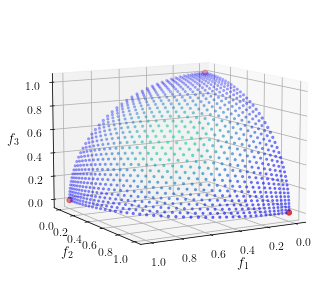

../../data/dtlz2-nbi/4d/f.csv (1771, 4) dtlz2-nbi
../../data/dtlz2-nbi/4d/x.csv (1771, 3) dtlz2-nbi
Loading depth contours from ../../data/dtlz2-nbi/4d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/dtlz2-nbi/4d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [6.123233995736766e-17, 1.0, 1.0], [-1.0, 1.2246467991473532e-16, 1.0], [-1.8369701987210297e-16, -1.0, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [6.123233995736766e-17, 1.0, 0.8], [-1.0, 1.2246467991473532e-16, 0.8], [-1.8369701987210297e-16, -1.0, 0.8], [1.0, 0.0, 0.8]], [[1.0, 0.0, 0.6000000000000001], [6.123233995736766e-17, 1.0, 0.6000000000000001], [-1.0, 1.2246467991473532e-16, 0.6000000000000001], [-1.8369701987210297e-16, -1.0, 0.6000000000000001], [1.0, 0.0, 0.6000000000000001]], [[1.0, 0.0, 0.4000000000000001], [6.123233995736766e-17, 1.0, 0.4000000000000001], [-1.0, 1.2246467991473532e-16, 0.4000000000000001], [-1.8369701987210297e-16, -1.0, 0.4000000000000001], [1.0, 0.0, 0.4000000000000001]], [[1.0, 0.0, 0.2

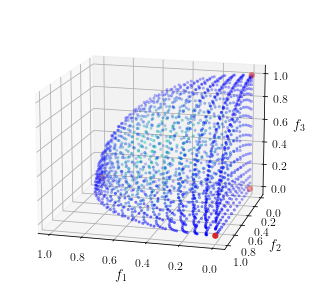

../../data/dtlz2-nbi/8d/f.csv (3432, 8) dtlz2-nbi
../../data/dtlz2-nbi/8d/x.csv (3432, 7) dtlz2-nbi
Loading depth contours from ../../data/dtlz2-nbi/8d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/dtlz2-nbi/8d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [0.7071067811865476, 0.7071067811865475, 1.0], [6.123233995736766e-17, 1.0, 1.0], [-0.7071067811865475, 0.7071067811865476, 1.0], [-1.0, 1.2246467991473532e-16, 1.0], [-0.7071067811865477, -0.7071067811865475, 1.0], [-1.8369701987210297e-16, -1.0, 1.0], [0.7071067811865475, -0.7071067811865477, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [0.7071067811865476, 0.7071067811865475, 0.8], [6.123233995736766e-17, 1.0, 0.8], [-0.7071067811865475, 0.7071067811865476, 0.8], [-1.0, 1.2246467991473532e-16, 0.8], [-0.7071067811865477, -0.7071067811865475, 0.8], [-1.8369701987210297e-16, -1.0, 0.8], [0.7071067811865475, -0.7071067811865477, 0.8], [1.0, 0.0, 0.8]], [[1.0, 0.0, 0.6000000000000001], [0.7071067811865476, 0.7071067811865475,

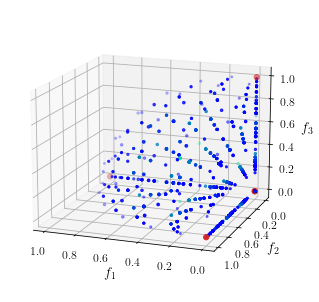

../../data/debmdk-nbi/3d/f.csv (1143, 3) debmdk-nbi
../../data/debmdk-nbi/3d/x.csv (1143, 2) debmdk-nbi
Loading depth contours from ../../data/debmdk-nbi/3d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/debmdk-nbi/3d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [-0.4999999999999998, 0.8660254037844388, 1.0], [-0.5000000000000004, -0.8660254037844384, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [-0.4999999999999998, 0.8660254037844388, 0.8], [-0.5000000000000004, -0.8660254037844384, 0.8], [1.0, 0.0, 0.8]], [[1.0, 0.0, 0.6000000000000001], [-0.4999999999999998, 0.8660254037844388, 0.6000000000000001], [-0.5000000000000004, -0.8660254037844384, 0.6000000000000001], [1.0, 0.0, 0.6000000000000001]], [[1.0, 0.0, 0.4000000000000001], [-0.4999999999999998, 0.8660254037844388, 0.4000000000000001], [-0.5000000000000004, -0.8660254037844384, 0.4000000000000001], [1.0, 0.0, 0.4000000000000001]], [[1.0, 0.0, 0.20000000000000007], [-0.4999999999999998, 0.8660254037844388, 0.2000000000000

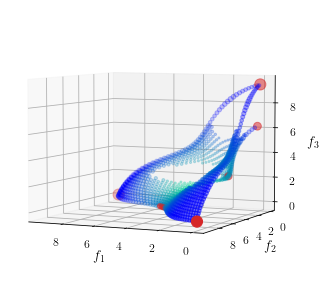

../../data/debmdk-nbi/4d/f.csv (2028, 4) debmdk-nbi
../../data/debmdk-nbi/4d/x.csv (2028, 3) debmdk-nbi
Loading depth contours from ../../data/debmdk-nbi/4d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/debmdk-nbi/4d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [6.123233995736766e-17, 1.0, 1.0], [-1.0, 1.2246467991473532e-16, 1.0], [-1.8369701987210297e-16, -1.0, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [6.123233995736766e-17, 1.0, 0.8], [-1.0, 1.2246467991473532e-16, 0.8], [-1.8369701987210297e-16, -1.0, 0.8], [1.0, 0.0, 0.8]], [[1.0, 0.0, 0.6000000000000001], [6.123233995736766e-17, 1.0, 0.6000000000000001], [-1.0, 1.2246467991473532e-16, 0.6000000000000001], [-1.8369701987210297e-16, -1.0, 0.6000000000000001], [1.0, 0.0, 0.6000000000000001]], [[1.0, 0.0, 0.4000000000000001], [6.123233995736766e-17, 1.0, 0.4000000000000001], [-1.0, 1.2246467991473532e-16, 0.4000000000000001], [-1.8369701987210297e-16, -1.0, 0.4000000000000001], [1.0, 0.0, 0.4000000000000001]], [[1.0, 0.

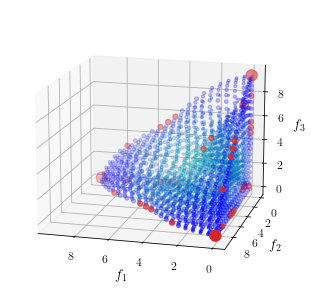

../../data/debmdk-nbi/8d/f.csv (3432, 8) debmdk-nbi
../../data/debmdk-nbi/8d/x.csv (3432, 7) debmdk-nbi
Loading depth contours from ../../data/debmdk-nbi/8d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/debmdk-nbi/8d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [0.7071067811865476, 0.7071067811865475, 1.0], [6.123233995736766e-17, 1.0, 1.0], [-0.7071067811865475, 0.7071067811865476, 1.0], [-1.0, 1.2246467991473532e-16, 1.0], [-0.7071067811865477, -0.7071067811865475, 1.0], [-1.8369701987210297e-16, -1.0, 1.0], [0.7071067811865475, -0.7071067811865477, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.75], [0.7071067811865476, 0.7071067811865475, 0.75], [6.123233995736766e-17, 1.0, 0.75], [-0.7071067811865475, 0.7071067811865476, 0.75], [-1.0, 1.2246467991473532e-16, 0.75], [-0.7071067811865477, -0.7071067811865475, 0.75], [-1.8369701987210297e-16, -1.0, 0.75], [0.7071067811865475, -0.7071067811865477, 0.75], [1.0, 0.0, 0.75]], [[1.0, 0.0, 0.5], [0.7071067811865476, 0.7071067811865475,

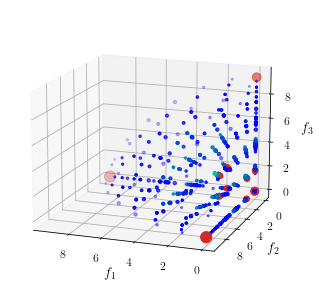

../../data/debmdk-all-nbi/3d/f.csv (990, 3) debmdk-all-nbi
../../data/debmdk-all-nbi/3d/x.csv (990, 2) debmdk-all-nbi
Loading depth contours from ../../data/debmdk-all-nbi/3d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/debmdk-all-nbi/3d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [-0.4999999999999998, 0.8660254037844388, 1.0], [-0.5000000000000004, -0.8660254037844384, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [-0.4999999999999998, 0.8660254037844388, 0.8], [-0.5000000000000004, -0.8660254037844384, 0.8], [1.0, 0.0, 0.8]], [[1.0, 0.0, 0.6000000000000001], [-0.4999999999999998, 0.8660254037844388, 0.6000000000000001], [-0.5000000000000004, -0.8660254037844384, 0.6000000000000001], [1.0, 0.0, 0.6000000000000001]], [[1.0, 0.0, 0.4000000000000001], [-0.4999999999999998, 0.8660254037844388, 0.4000000000000001], [-0.5000000000000004, -0.8660254037844384, 0.4000000000000001], [1.0, 0.0, 0.4000000000000001]], [[1.0, 0.0, 0.20000000000000007], [-0.4999999999999998, 0.86602540378

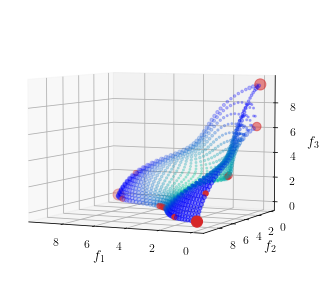

../../data/debmdk-all-nbi/4d/f.csv (1771, 4) debmdk-all-nbi
../../data/debmdk-all-nbi/4d/x.csv (1771, 3) debmdk-all-nbi
Loading depth contours from ../../data/debmdk-all-nbi/4d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/debmdk-all-nbi/4d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [6.123233995736766e-17, 1.0, 1.0], [-1.0, 1.2246467991473532e-16, 1.0], [-1.8369701987210297e-16, -1.0, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [6.123233995736766e-17, 1.0, 0.8], [-1.0, 1.2246467991473532e-16, 0.8], [-1.8369701987210297e-16, -1.0, 0.8], [1.0, 0.0, 0.8]], [[1.0, 0.0, 0.6000000000000001], [6.123233995736766e-17, 1.0, 0.6000000000000001], [-1.0, 1.2246467991473532e-16, 0.6000000000000001], [-1.8369701987210297e-16, -1.0, 0.6000000000000001], [1.0, 0.0, 0.6000000000000001]], [[1.0, 0.0, 0.4000000000000001], [6.123233995736766e-17, 1.0, 0.4000000000000001], [-1.0, 1.2246467991473532e-16, 0.4000000000000001], [-1.8369701987210297e-16, -1.0, 0.4000000000000001], [1.0, 0.0, 0.40000

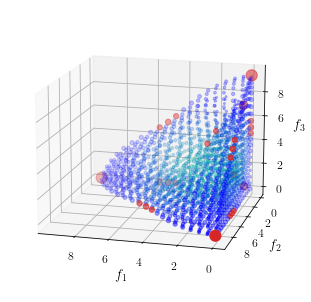

../../data/debmdk-all-nbi/8d/f.csv (3432, 8) debmdk-all-nbi
../../data/debmdk-all-nbi/8d/x.csv (3432, 7) debmdk-all-nbi
Loading depth contours from ../../data/debmdk-all-nbi/8d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/debmdk-all-nbi/8d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [0.7071067811865476, 0.7071067811865475, 1.0], [6.123233995736766e-17, 1.0, 1.0], [-0.7071067811865475, 0.7071067811865476, 1.0], [-1.0, 1.2246467991473532e-16, 1.0], [-0.7071067811865477, -0.7071067811865475, 1.0], [-1.8369701987210297e-16, -1.0, 1.0], [0.7071067811865475, -0.7071067811865477, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.75], [0.7071067811865476, 0.7071067811865475, 0.75], [6.123233995736766e-17, 1.0, 0.75], [-0.7071067811865475, 0.7071067811865476, 0.75], [-1.0, 1.2246467991473532e-16, 0.75], [-0.7071067811865477, -0.7071067811865475, 0.75], [-1.8369701987210297e-16, -1.0, 0.75], [0.7071067811865475, -0.7071067811865477, 0.75], [1.0, 0.0, 0.75]], [[1.0, 0.0, 0.5], [0.7071067811865

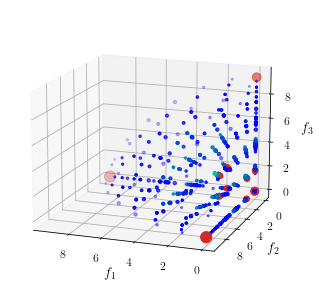

../../data/dtlz8-nbi/3d/f.csv (1025, 3) dtlz8-nbi
../../data/dtlz8-nbi/3d/x.csv (1025, 2) dtlz8-nbi
../../data/dtlz8-nbi/3d/g.csv (1025, 3) dtlz8-nbi
Loading depth contours from ../../data/dtlz8-nbi/3d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/dtlz8-nbi/3d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [-0.4999999999999998, 0.8660254037844388, 1.0], [-0.5000000000000004, -0.8660254037844384, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [-0.4999999999999998, 0.8660254037844388, 0.8], [-0.5000000000000004, -0.8660254037844384, 0.8], [1.0, 0.0, 0.8]], [[1.0, 0.0, 0.6000000000000001], [-0.4999999999999998, 0.8660254037844388, 0.6000000000000001], [-0.5000000000000004, -0.8660254037844384, 0.6000000000000001], [1.0, 0.0, 0.6000000000000001]], [[1.0, 0.0, 0.4000000000000001], [-0.4999999999999998, 0.8660254037844388, 0.4000000000000001], [-0.5000000000000004, -0.8660254037844384, 0.4000000000000001], [1.0, 0.0, 0.4000000000000001]], [[1.0, 0.0, 0.20000000000000007], [-0.499999999

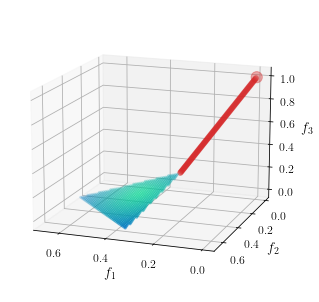

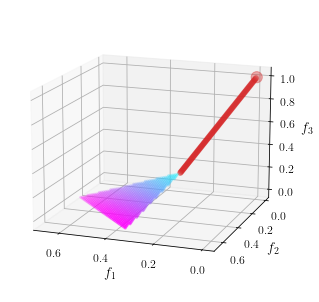

../../data/dtlz8-nbi/4d/f.csv (2088, 4) dtlz8-nbi
../../data/dtlz8-nbi/4d/x.csv (2088, 3) dtlz8-nbi
../../data/dtlz8-nbi/4d/g.csv (2088, 4) dtlz8-nbi
Loading depth contours from ../../data/dtlz8-nbi/4d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/dtlz8-nbi/4d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [6.123233995736766e-17, 1.0, 1.0], [-1.0, 1.2246467991473532e-16, 1.0], [-1.8369701987210297e-16, -1.0, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [6.123233995736766e-17, 1.0, 0.8], [-1.0, 1.2246467991473532e-16, 0.8], [-1.8369701987210297e-16, -1.0, 0.8], [1.0, 0.0, 0.8]], [[1.0, 0.0, 0.6000000000000001], [6.123233995736766e-17, 1.0, 0.6000000000000001], [-1.0, 1.2246467991473532e-16, 0.6000000000000001], [-1.8369701987210297e-16, -1.0, 0.6000000000000001], [1.0, 0.0, 0.6000000000000001]], [[1.0, 0.0, 0.4000000000000001], [6.123233995736766e-17, 1.0, 0.4000000000000001], [-1.0, 1.2246467991473532e-16, 0.4000000000000001], [-1.8369701987210297e-16, -1.0, 0.4000000000000001]

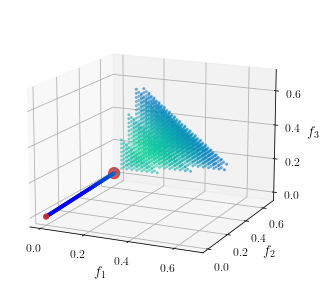

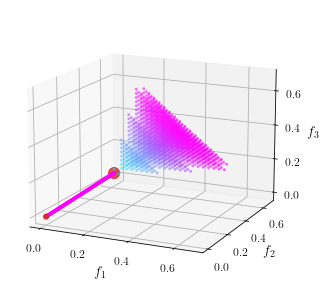

../../data/dtlz8-nbi/6d/f.csv (3535, 6) dtlz8-nbi
../../data/dtlz8-nbi/6d/x.csv (3535, 5) dtlz8-nbi
../../data/dtlz8-nbi/6d/g.csv (3535, 6) dtlz8-nbi
Loading depth contours from ../../data/dtlz8-nbi/6d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/dtlz8-nbi/6d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [0.5000000000000001, 0.8660254037844386, 1.0], [-0.4999999999999998, 0.8660254037844388, 1.0], [-1.0, 1.2246467991473532e-16, 1.0], [-0.5000000000000004, -0.8660254037844384, 1.0], [0.5, -0.8660254037844386, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [0.5000000000000001, 0.8660254037844386, 0.8], [-0.4999999999999998, 0.8660254037844388, 0.8], [-1.0, 1.2246467991473532e-16, 0.8], [-0.5000000000000004, -0.8660254037844384, 0.8], [0.5, -0.8660254037844386, 0.8], [1.0, 0.0, 0.8]], [[1.0, 0.0, 0.6000000000000001], [0.5000000000000001, 0.8660254037844386, 0.6000000000000001], [-0.4999999999999998, 0.8660254037844388, 0.6000000000000001], [-1.0, 1.2246467991473532e-16, 0.60000000

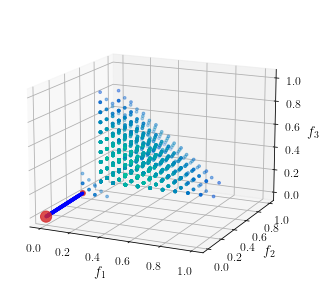

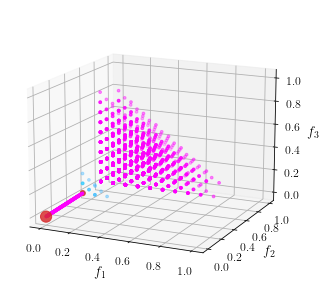

../../data/dtlz8-nbi/8d/f.csv (2277, 8) dtlz8-nbi
../../data/dtlz8-nbi/8d/x.csv (2277, 7) dtlz8-nbi
../../data/dtlz8-nbi/8d/g.csv (2277, 8) dtlz8-nbi
Loading depth contours from ../../data/dtlz8-nbi/8d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/dtlz8-nbi/8d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [0.7071067811865476, 0.7071067811865475, 1.0], [6.123233995736766e-17, 1.0, 1.0], [-0.7071067811865475, 0.7071067811865476, 1.0], [-1.0, 1.2246467991473532e-16, 1.0], [-0.7071067811865477, -0.7071067811865475, 1.0], [-1.8369701987210297e-16, -1.0, 1.0], [0.7071067811865475, -0.7071067811865477, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [0.7071067811865476, 0.7071067811865475, 0.8], [6.123233995736766e-17, 1.0, 0.8], [-0.7071067811865475, 0.7071067811865476, 0.8], [-1.0, 1.2246467991473532e-16, 0.8], [-0.7071067811865477, -0.7071067811865475, 0.8], [-1.8369701987210297e-16, -1.0, 0.8], [0.7071067811865475, -0.7071067811865477, 0.8], [1.0, 0.0, 0.8]], [[1.0, 0.0, 0.600000000

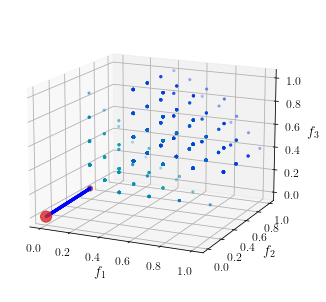

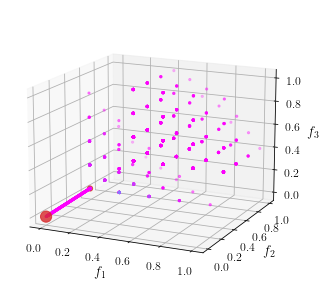

../../data/c2dtlz2-nbi/3d/f.csv (1036, 3) c2dtlz2-nbi
../../data/c2dtlz2-nbi/3d/x.csv (1036, 2) c2dtlz2-nbi
../../data/c2dtlz2-nbi/3d/g.csv (1036,) c2dtlz2-nbi
Loading depth contours from ../../data/c2dtlz2-nbi/3d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/c2dtlz2-nbi/3d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [-0.4999999999999998, 0.8660254037844388, 1.0], [-0.5000000000000004, -0.8660254037844384, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [-0.4999999999999998, 0.8660254037844388, 0.8], [-0.5000000000000004, -0.8660254037844384, 0.8], [1.0, 0.0, 0.8]], [[1.0, 0.0, 0.6000000000000001], [-0.4999999999999998, 0.8660254037844388, 0.6000000000000001], [-0.5000000000000004, -0.8660254037844384, 0.6000000000000001], [1.0, 0.0, 0.6000000000000001]], [[1.0, 0.0, 0.4000000000000001], [-0.4999999999999998, 0.8660254037844388, 0.4000000000000001], [-0.5000000000000004, -0.8660254037844384, 0.4000000000000001], [1.0, 0.0, 0.4000000000000001]], [[1.0, 0.0, 0.20000000000000007],

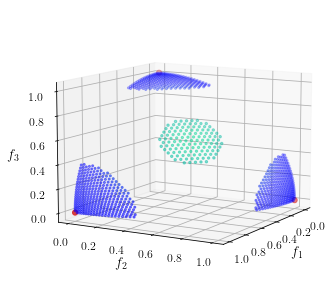

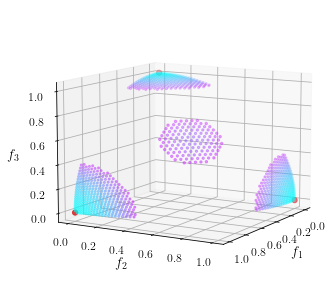

../../data/c2dtlz2-nbi/4d/f.csv (1984, 4) c2dtlz2-nbi
../../data/c2dtlz2-nbi/4d/x.csv (1984, 3) c2dtlz2-nbi
../../data/c2dtlz2-nbi/4d/g.csv (1984,) c2dtlz2-nbi
Loading depth contours from ../../data/c2dtlz2-nbi/4d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/c2dtlz2-nbi/4d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [6.123233995736766e-17, 1.0, 1.0], [-1.0, 1.2246467991473532e-16, 1.0], [-1.8369701987210297e-16, -1.0, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [6.123233995736766e-17, 1.0, 0.8], [-1.0, 1.2246467991473532e-16, 0.8], [-1.8369701987210297e-16, -1.0, 0.8], [1.0, 0.0, 0.8]], [[1.0, 0.0, 0.6000000000000001], [6.123233995736766e-17, 1.0, 0.6000000000000001], [-1.0, 1.2246467991473532e-16, 0.6000000000000001], [-1.8369701987210297e-16, -1.0, 0.6000000000000001], [1.0, 0.0, 0.6000000000000001]], [[1.0, 0.0, 0.4000000000000001], [6.123233995736766e-17, 1.0, 0.4000000000000001], [-1.0, 1.2246467991473532e-16, 0.4000000000000001], [-1.8369701987210297e-16, -1.0, 0.400

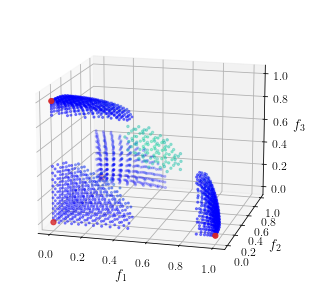

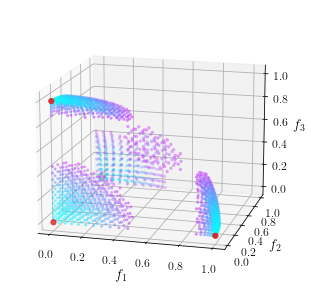

../../data/c2dtlz2-nbi/5d/f.csv (2280, 5) c2dtlz2-nbi
../../data/c2dtlz2-nbi/5d/x.csv (2280, 4) c2dtlz2-nbi
../../data/c2dtlz2-nbi/5d/g.csv (2280,) c2dtlz2-nbi
Loading depth contours from ../../data/c2dtlz2-nbi/5d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/c2dtlz2-nbi/5d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [0.30901699437494745, 0.9510565162951535, 1.0], [-0.8090169943749473, 0.5877852522924732, 1.0], [-0.8090169943749475, -0.587785252292473, 1.0], [0.30901699437494723, -0.9510565162951536, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.75], [0.30901699437494745, 0.9510565162951535, 0.75], [-0.8090169943749473, 0.5877852522924732, 0.75], [-0.8090169943749475, -0.587785252292473, 0.75], [0.30901699437494723, -0.9510565162951536, 0.75], [1.0, 0.0, 0.75]], [[1.0, 0.0, 0.5], [0.30901699437494745, 0.9510565162951535, 0.5], [-0.8090169943749473, 0.5877852522924732, 0.5], [-0.8090169943749475, -0.587785252292473, 0.5], [0.30901699437494723, -0.9510565162951536, 0.5], [1.0, 0.0,

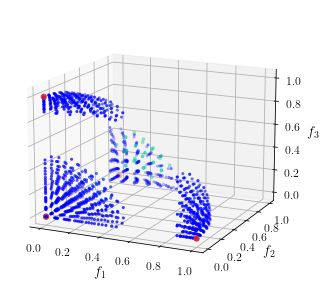

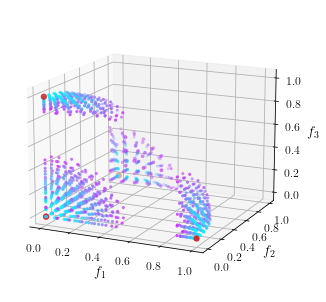

../../data/c2dtlz2-nbi/8d/f.csv (3872, 8) c2dtlz2-nbi
../../data/c2dtlz2-nbi/8d/x.csv (3872, 7) c2dtlz2-nbi
../../data/c2dtlz2-nbi/8d/g.csv (3872,) c2dtlz2-nbi
Loading depth contours from ../../data/c2dtlz2-nbi/8d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/c2dtlz2-nbi/8d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [0.7071067811865476, 0.7071067811865475, 1.0], [6.123233995736766e-17, 1.0, 1.0], [-0.7071067811865475, 0.7071067811865476, 1.0], [-1.0, 1.2246467991473532e-16, 1.0], [-0.7071067811865477, -0.7071067811865475, 1.0], [-1.8369701987210297e-16, -1.0, 1.0], [0.7071067811865475, -0.7071067811865477, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [0.7071067811865476, 0.7071067811865475, 0.8], [6.123233995736766e-17, 1.0, 0.8], [-0.7071067811865475, 0.7071067811865476, 0.8], [-1.0, 1.2246467991473532e-16, 0.8], [-0.7071067811865477, -0.7071067811865475, 0.8], [-1.8369701987210297e-16, -1.0, 0.8], [0.7071067811865475, -0.7071067811865477, 0.8], [1.0, 0.0, 0.8]], [[1.0, 0.

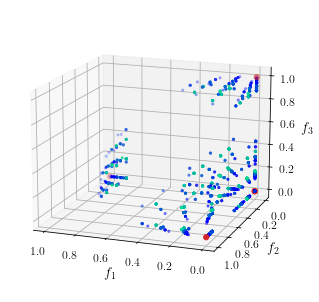

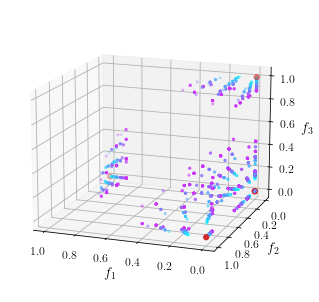

../../data/cdebmdk-nbi/3d/f.csv (1049, 3) cdebmdk-nbi
../../data/cdebmdk-nbi/3d/x.csv (1049, 2) cdebmdk-nbi
../../data/cdebmdk-nbi/3d/g.csv (1049,) cdebmdk-nbi
Loading depth contours from ../../data/cdebmdk-nbi/3d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/cdebmdk-nbi/3d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [-0.4999999999999998, 0.8660254037844388, 1.0], [-0.5000000000000004, -0.8660254037844384, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [-0.4999999999999998, 0.8660254037844388, 0.8], [-0.5000000000000004, -0.8660254037844384, 0.8], [1.0, 0.0, 0.8]], [[1.0, 0.0, 0.6000000000000001], [-0.4999999999999998, 0.8660254037844388, 0.6000000000000001], [-0.5000000000000004, -0.8660254037844384, 0.6000000000000001], [1.0, 0.0, 0.6000000000000001]], [[1.0, 0.0, 0.4000000000000001], [-0.4999999999999998, 0.8660254037844388, 0.4000000000000001], [-0.5000000000000004, -0.8660254037844384, 0.4000000000000001], [1.0, 0.0, 0.4000000000000001]], [[1.0, 0.0, 0.20000000000000007],

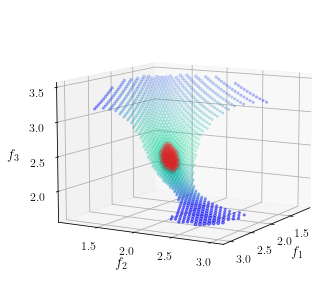

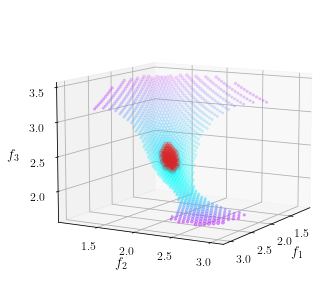

../../data/cdebmdk-nbi/4d/f.csv (2042, 4) cdebmdk-nbi
../../data/cdebmdk-nbi/4d/x.csv (2042, 3) cdebmdk-nbi
../../data/cdebmdk-nbi/4d/g.csv (2042,) cdebmdk-nbi
Loading depth contours from ../../data/cdebmdk-nbi/4d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/cdebmdk-nbi/4d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [6.123233995736766e-17, 1.0, 1.0], [-1.0, 1.2246467991473532e-16, 1.0], [-1.8369701987210297e-16, -1.0, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [6.123233995736766e-17, 1.0, 0.8], [-1.0, 1.2246467991473532e-16, 0.8], [-1.8369701987210297e-16, -1.0, 0.8], [1.0, 0.0, 0.8]], [[1.0, 0.0, 0.6000000000000001], [6.123233995736766e-17, 1.0, 0.6000000000000001], [-1.0, 1.2246467991473532e-16, 0.6000000000000001], [-1.8369701987210297e-16, -1.0, 0.6000000000000001], [1.0, 0.0, 0.6000000000000001]], [[1.0, 0.0, 0.4000000000000001], [6.123233995736766e-17, 1.0, 0.4000000000000001], [-1.0, 1.2246467991473532e-16, 0.4000000000000001], [-1.8369701987210297e-16, -1.0, 0.400

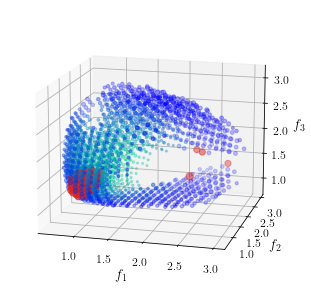

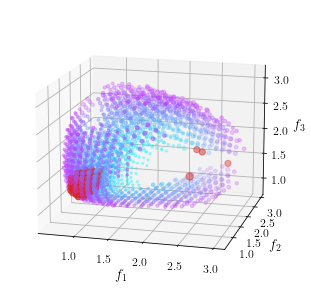

../../data/cdebmdk-nbi/8d/f.csv (3380, 8) cdebmdk-nbi
../../data/cdebmdk-nbi/8d/x.csv (3380, 7) cdebmdk-nbi
../../data/cdebmdk-nbi/8d/g.csv (3380,) cdebmdk-nbi
Loading depth contours from ../../data/cdebmdk-nbi/8d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/cdebmdk-nbi/8d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [0.7071067811865476, 0.7071067811865475, 1.0], [6.123233995736766e-17, 1.0, 1.0], [-0.7071067811865475, 0.7071067811865476, 1.0], [-1.0, 1.2246467991473532e-16, 1.0], [-0.7071067811865477, -0.7071067811865475, 1.0], [-1.8369701987210297e-16, -1.0, 1.0], [0.7071067811865475, -0.7071067811865477, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [0.7071067811865476, 0.7071067811865475, 0.8], [6.123233995736766e-17, 1.0, 0.8], [-0.7071067811865475, 0.7071067811865476, 0.8], [-1.0, 1.2246467991473532e-16, 0.8], [-0.7071067811865477, -0.7071067811865475, 0.8], [-1.8369701987210297e-16, -1.0, 0.8], [0.7071067811865475, -0.7071067811865477, 0.8], [1.0, 0.0, 0.8]], [[1.0, 0.

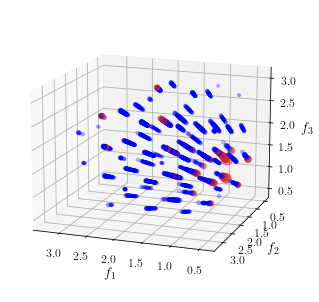

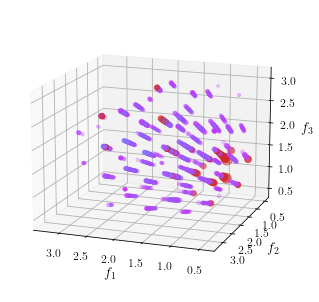

../../data/c0dtlz2-nbi/3d/f.csv (983, 3) c0dtlz2-nbi
../../data/c0dtlz2-nbi/3d/x.csv (983, 2) c0dtlz2-nbi
../../data/c0dtlz2-nbi/3d/g.csv (983,) c0dtlz2-nbi
Loading depth contours from ../../data/c0dtlz2-nbi/3d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/c0dtlz2-nbi/3d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [-0.4999999999999998, 0.8660254037844388, 1.0], [-0.5000000000000004, -0.8660254037844384, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [-0.4999999999999998, 0.8660254037844388, 0.8], [-0.5000000000000004, -0.8660254037844384, 0.8], [1.0, 0.0, 0.8]], [[1.0, 0.0, 0.6000000000000001], [-0.4999999999999998, 0.8660254037844388, 0.6000000000000001], [-0.5000000000000004, -0.8660254037844384, 0.6000000000000001], [1.0, 0.0, 0.6000000000000001]], [[1.0, 0.0, 0.4000000000000001], [-0.4999999999999998, 0.8660254037844388, 0.4000000000000001], [-0.5000000000000004, -0.8660254037844384, 0.4000000000000001], [1.0, 0.0, 0.4000000000000001]], [[1.0, 0.0, 0.20000000000000007], [-

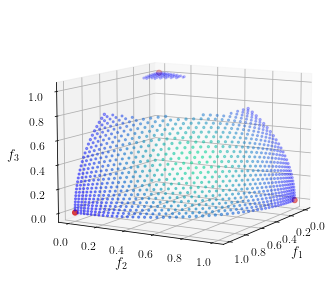

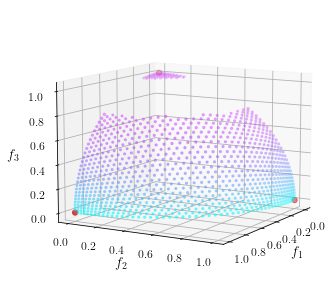

../../data/c0dtlz2-nbi/4d/f.csv (1916, 4) c0dtlz2-nbi
../../data/c0dtlz2-nbi/4d/x.csv (1916, 3) c0dtlz2-nbi
../../data/c0dtlz2-nbi/4d/g.csv (1916,) c0dtlz2-nbi
Loading depth contours from ../../data/c0dtlz2-nbi/4d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/c0dtlz2-nbi/4d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [6.123233995736766e-17, 1.0, 1.0], [-1.0, 1.2246467991473532e-16, 1.0], [-1.8369701987210297e-16, -1.0, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [6.123233995736766e-17, 1.0, 0.8], [-1.0, 1.2246467991473532e-16, 0.8], [-1.8369701987210297e-16, -1.0, 0.8], [1.0, 0.0, 0.8]], [[1.0, 0.0, 0.6000000000000001], [6.123233995736766e-17, 1.0, 0.6000000000000001], [-1.0, 1.2246467991473532e-16, 0.6000000000000001], [-1.8369701987210297e-16, -1.0, 0.6000000000000001], [1.0, 0.0, 0.6000000000000001]], [[1.0, 0.0, 0.4000000000000001], [6.123233995736766e-17, 1.0, 0.4000000000000001], [-1.0, 1.2246467991473532e-16, 0.4000000000000001], [-1.8369701987210297e-16, -1.0, 0.400

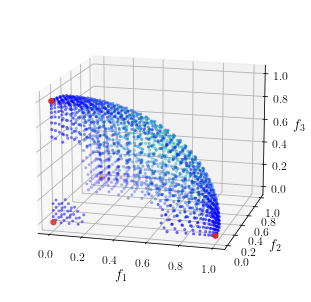

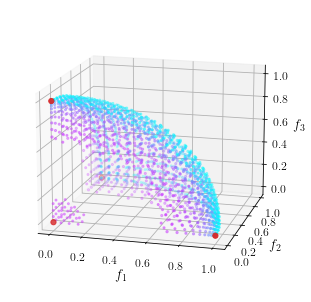

../../data/c0dtlz2-nbi/8d/f.csv (3180, 8) c0dtlz2-nbi
../../data/c0dtlz2-nbi/8d/x.csv (3180, 7) c0dtlz2-nbi
../../data/c0dtlz2-nbi/8d/g.csv (3180,) c0dtlz2-nbi
Loading depth contours from ../../data/c0dtlz2-nbi/8d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/c0dtlz2-nbi/8d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [0.7071067811865476, 0.7071067811865475, 1.0], [6.123233995736766e-17, 1.0, 1.0], [-0.7071067811865475, 0.7071067811865476, 1.0], [-1.0, 1.2246467991473532e-16, 1.0], [-0.7071067811865477, -0.7071067811865475, 1.0], [-1.8369701987210297e-16, -1.0, 1.0], [0.7071067811865475, -0.7071067811865477, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.6666666666666667], [0.7071067811865476, 0.7071067811865475, 0.6666666666666667], [6.123233995736766e-17, 1.0, 0.6666666666666667], [-0.7071067811865475, 0.7071067811865476, 0.6666666666666667], [-1.0, 1.2246467991473532e-16, 0.6666666666666667], [-0.7071067811865477, -0.7071067811865475, 0.6666666666666667], [-1.8369701987210297e-1

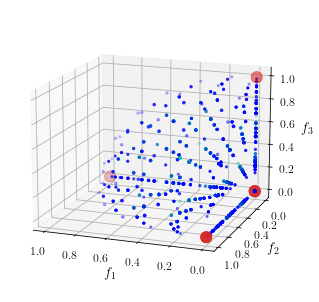

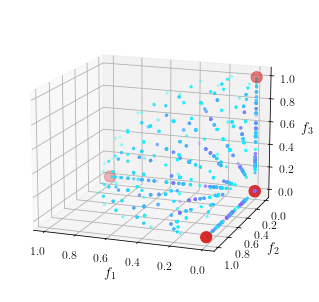

../../data/crash-nbi/3d/f.csv (4450, 3) crash-nbi
Loading depth contours from ../../data/crash-nbi/3d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/crash-nbi/3d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [-0.4999999999999998, 0.8660254037844388, 1.0], [-0.5000000000000004, -0.8660254037844384, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [-0.4999999999999998, 0.8660254037844388, 0.8], [-0.5000000000000004, -0.8660254037844384, 0.8], [1.0, 0.0, 0.8]], [[1.0, 0.0, 0.6000000000000001], [-0.4999999999999998, 0.8660254037844388, 0.6000000000000001], [-0.5000000000000004, -0.8660254037844384, 0.6000000000000001], [1.0, 0.0, 0.6000000000000001]], [[1.0, 0.0, 0.4000000000000001], [-0.4999999999999998, 0.8660254037844388, 0.4000000000000001], [-0.5000000000000004, -0.8660254037844384, 0.4000000000000001], [1.0, 0.0, 0.4000000000000001]], [[1.0, 0.0, 0.20000000000000007], [-0.4999999999999998, 0.8660254037844388, 0.20000000000000007], [-0.5000000000000004, -0.8660254037844384, 0.2000

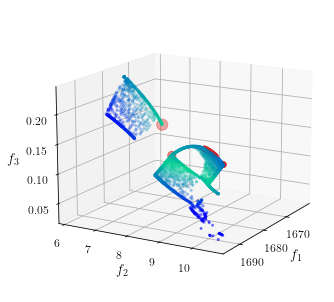

../../data/crash-c1-nbi/3d/f.csv (711, 3) crash-c1-nbi
Loading depth contours from ../../data/crash-c1-nbi/3d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/crash-c1-nbi/3d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [-0.4999999999999998, 0.8660254037844388, 1.0], [-0.5000000000000004, -0.8660254037844384, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [-0.4999999999999998, 0.8660254037844388, 0.8], [-0.5000000000000004, -0.8660254037844384, 0.8], [1.0, 0.0, 0.8]], [[1.0, 0.0, 0.6000000000000001], [-0.4999999999999998, 0.8660254037844388, 0.6000000000000001], [-0.5000000000000004, -0.8660254037844384, 0.6000000000000001], [1.0, 0.0, 0.6000000000000001]], [[1.0, 0.0, 0.4000000000000001], [-0.4999999999999998, 0.8660254037844388, 0.4000000000000001], [-0.5000000000000004, -0.8660254037844384, 0.4000000000000001], [1.0, 0.0, 0.4000000000000001]], [[1.0, 0.0, 0.20000000000000007], [-0.4999999999999998, 0.8660254037844388, 0.20000000000000007], [-0.5000000000000004, -0.8660254037844

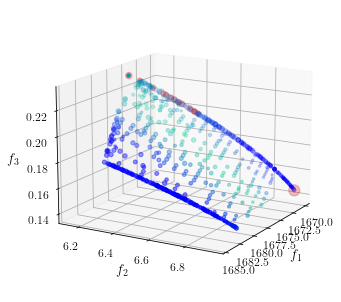

../../data/crash-c2-nbi/3d/f.csv (3739, 3) crash-c2-nbi
Loading depth contours from ../../data/crash-c2-nbi/3d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/crash-c2-nbi/3d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [-0.4999999999999998, 0.8660254037844388, 1.0], [-0.5000000000000004, -0.8660254037844384, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [-0.4999999999999998, 0.8660254037844388, 0.8], [-0.5000000000000004, -0.8660254037844384, 0.8], [1.0, 0.0, 0.8]], [[1.0, 0.0, 0.6000000000000001], [-0.4999999999999998, 0.8660254037844388, 0.6000000000000001], [-0.5000000000000004, -0.8660254037844384, 0.6000000000000001], [1.0, 0.0, 0.6000000000000001]], [[1.0, 0.0, 0.4000000000000001], [-0.4999999999999998, 0.8660254037844388, 0.4000000000000001], [-0.5000000000000004, -0.8660254037844384, 0.4000000000000001], [1.0, 0.0, 0.4000000000000001]], [[1.0, 0.0, 0.20000000000000007], [-0.4999999999999998, 0.8660254037844388, 0.20000000000000007], [-0.5000000000000004, -0.866025403784

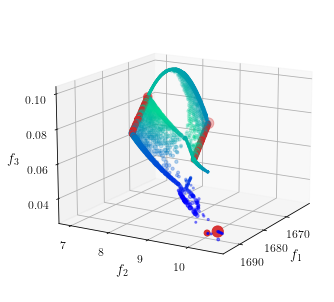

../../data/gaa-nbi/10d/f.csv (3112, 10) gaa-nbi
Loading depth contours from ../../data/gaa-nbi/10d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/gaa-nbi/10d/depth-cont-cvhull.csv.
[[[1.0, 0.0, 1.0], [0.8090169943749475, 0.5877852522924731, 1.0], [0.30901699437494745, 0.9510565162951535, 1.0], [-0.30901699437494734, 0.9510565162951536, 1.0], [-0.8090169943749473, 0.5877852522924732, 1.0], [-1.0, 1.2246467991473532e-16, 1.0], [-0.8090169943749475, -0.587785252292473, 1.0], [-0.30901699437494756, -0.9510565162951535, 1.0], [0.30901699437494723, -0.9510565162951536, 1.0], [0.8090169943749473, -0.5877852522924732, 1.0], [1.0, 0.0, 1.0]], [[1.0, 0.0, 0.8], [0.8090169943749475, 0.5877852522924731, 0.8], [0.30901699437494745, 0.9510565162951535, 0.8], [-0.30901699437494734, 0.9510565162951536, 0.8], [-0.8090169943749473, 0.5877852522924732, 0.8], [-1.0, 1.2246467991473532e-16, 0.8], [-0.8090169943749475, -0.587785252292473, 0.8], [-0.30901699437494756, -0.9510565162951535, 0.8]

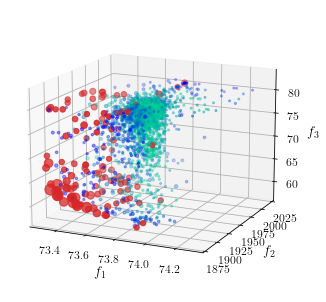

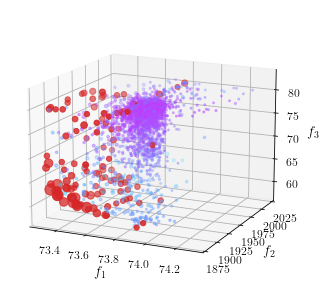

In [6]:
import pathlib
from viz.utils import io
from viz.plotting import scatter
from viz.plotting.scatter import camera_angles
from viz.plotting.paletteviz import get_palette_radviz_coordinates, get_palette_star_coordinates
from viz.plotting.radviz import get_radviz_coordinates
from viz.plotting.star import get_star_coordinates


pfs = {'dtlz2': ['3d', '4d', '8d'], \
       'debmdk': ['3d', '4d', '8d'], \
       'debmdk-all': ['3d', '4d', '8d'], \
       'dtlz8': ['3d', '4d', '6d', '8d'], \
       'c2dtlz2': ['3d', '4d', '5d', '8d'], \
       'cdebmdk': ['3d', '4d', '8d'], \
       'c0dtlz2': ['3d', '4d', '8d'], \
       'gaa': ['10d']}

pfs_nbi = {
    'dtlz2-nbi': ['3d', '4d', '8d'], \
    'debmdk-nbi': ['3d', '4d', '8d'], \
    'debmdk-all-nbi': ['3d', '4d', '8d'], \
    'dtlz8-nbi': ['3d', '4d', '6d', '8d'], \
    'c2dtlz2-nbi': ['3d', '4d', '5d', '8d'], \
    'cdebmdk-nbi': ['3d', '4d', '8d'], \
    'c0dtlz2-nbi': ['3d', '4d', '8d'], \
    'crash-nbi': ['3d'], 'crash-c1-nbi': ['3d'], 'crash-c2-nbi': ['3d'], \
    'gaa-nbi': ['10d']}

constrained_pfs = ['dtlz8', 'dtlz8-nbi', 'c2dtlz2', 'c2dtlz2-nbi', 'cdebmdk', 'cdebmdk-nbi', \
                   'c0dtlz2', 'c0dtlz2-nbi', 'gaa', 'gaa-nbi']

for pf in list(pfs_nbi.keys()):
    for dim in pfs_nbi[pf]:
        fullpathf = "../../data/{0:s}/{1:s}/f.csv".format(pf, dim)
        destpath = "./data/{0:s}/{1:s}".format(pf, dim)
        pathlib.Path(destpath).mkdir(parents=True, exist_ok=True)
        if os.path.exists(fullpathf):
            path, filenamef = os.path.split(fullpathf)
            frontname = path.split('/')[-2]
            fullpathx = os.path.join(path, 'x.csv')
            fullpathg = os.path.join(path, 'g.csv')
            
            # load the front
            F = np.loadtxt(fullpathf, delimiter=',')
            print(fullpathf, F.shape, frontname)
            
            X = None
            if os.path.exists(fullpathx):
                X = np.loadtxt(fullpathx, delimiter=',')
                print(fullpathx, X.shape, frontname)
            
            G = None
            if pf in constrained_pfs and os.path.exists(fullpathg):
                G = np.loadtxt(fullpathg, delimiter=',')
                print(fullpathg, G.shape, frontname)

            # decide color and size
            CV, Mu, Ik = load_props(path)
            S,Ccd,Ccv,D = decide_size_color(pf, dim, CV, Mu, Ik)
            
            # get the depth contour path
            depth_contour_path = os.path.join(path, "depth-cont-cvhull.csv")
            Dcvh = io.loadtxt(depth_contour_path, dtype=int, delimiter=',')
            if os.path.exists(depth_contour_path):
                Pr,Kpr,Bpr,Zpr = get_palette_radviz_coordinates(F, depth_contours=depth_contour_path, \
                                                          n_partitions=5, verbose=True)
                Ps,Kps,Bps,Zps = get_palette_star_coordinates(F, depth_contours=depth_contour_path, \
                                                          n_partitions=5, verbose=True)
            # get the radviz and star coordinates
            Cr,Kr,Br = get_radviz_coordinates(F)
            Cs,Ks,Bs = get_star_coordinates(F)

            # now generate index.js file
            dump_files(path=destpath, frontname=frontname, front=[F, X], knee=[Mu, Ik], centroid=[D, Ccd], \
                       constraints=[G, CV, Ccv], depths=[Dcvh], palette_rv=[Pr, Kpr, Bpr, Zpr], \
                       palette_sc=[Ps,Kps,Bps,Zps], radviz=[Cr,Kr,Br], star=[Cs,Ks,Bs])

            with plt.rc_context({"text.usetex": True, "font.size": 12}):
                # plot
                scatter.plot(F, ax=Axes3D(plt.figure()), s=S, c=Ccd, euler=camera_angles[pf][dim])
                if Ccv is not None:
                    scatter.plot(F, ax=Axes3D(plt.figure()), s=S, c=Ccv, euler=camera_angles[pf][dim])
                # show
                plt.show()